In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython

In [2]:
drum_raw = wavio.read("music/drum.wav")
fs = 16000
drum = drum_raw.data[0:4*fs, 0]
drum = drum.astype(np.float32, order='C') / 32767.0
padding = np.zeros(1024)
drum = np.append(padding, drum)
drum_norm = drum / np.abs(np.max(drum))

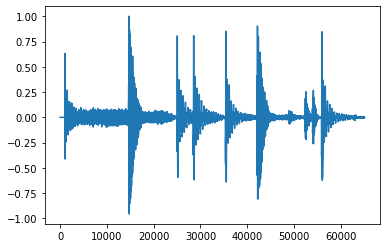

In [3]:
plt.plot(drum_norm)
plt.show()
IPython.display.display(IPython.display.Audio("music/drum.wav", rate=drum_raw.rate))

In [4]:
def rmse(input_data, overlap, frame):
    N = len(input_data)
    hop = int(overlap * frame)
    time = range(0, N, hop)
    en = np.zeros(len(time))
    for index, value in enumerate(time):
        powers = sum(input_data[value:value+frame]**2)
        en[index] = np.sqrt(powers/frame)
    return en

def env_diff(input_data):
    output_data = np.zeros(len(input_data))

    for index, value in enumerate(input_data):
        diff = input_data[index] - input_data[index-1]
        if diff < 0:
            pass
        else:
            output_data[index] = input_data[index] - input_data[index-1]
    return output_data


def peak_pick(xn, pre_max, post_max, pre_avg, post_avg, delta, wait):
    '''
    Uses a flexible heuristic to pick peaks in a signal.

    A sample n is selected as a peak if the corresponding x[n]
    fulfills the following three conditions:

    1. `x[n] == max(x[n - pre_max:n + post_max])`
    2. `x[n] >= mean(x[n - pre_avg:n + post_avg]) + delta`
    3. `n - previous_n > wait`
    '''
    output = np.array([])
    previous_n = 0
    for n, x in enumerate(xn):
        if n - pre_max > 0:
            case1 = (xn[n] == np.max(xn[n - pre_max:n + post_max]))
            case2 = (xn[n] >= np.mean(xn[n - pre_avg:n + post_avg]) + delta)
            case3 = (n - previous_n > wait)
            if (case1 and case2 and case3):
                output = np.append(output, [n])
                previous_n = n
    return output

In [5]:
frame = 32
overlap = 0.75

[  44.  615. 1043. 1189. 1475. 1759. 2187. 2252. 2330.]


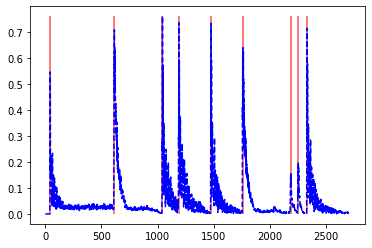

In [6]:
env = rmse(drum_norm, overlap, frame)
onset = peak_pick(env, 32, 32, 32, 32, 0.1, 32)
print(onset)
plt.plot(env, 'b--')    
plt.vlines(onset, 0, max(env), color='r', alpha=0.7)
plt.show()

[  44.  611. 1043. 1188. 1475. 1761. 2330.]


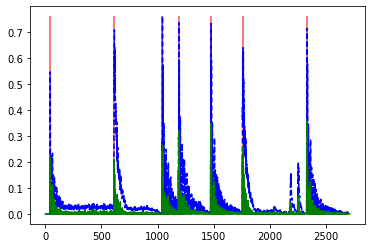

In [7]:
env = rmse(drum_norm, overlap, frame)
diff = env_diff(env)
onset = peak_pick(diff, 32, 32, 32, 32, 0.1, 32)
print(onset)
plt.plot(env, 'b--')    
plt.plot(diff, 'g')
plt.vlines(onset, 0, max(env), color='r', alpha=0.7)
plt.show()